Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or elise or stephan, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [1]:
NAMES = "YaChu Yang, JiunHan Chen"

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [3]:
from collections import defaultdict
from numpy.random import choice
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [4]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

In [5]:
# To have a quick look into the code
??env

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [6]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [7]:
# bulid reward matrix and next state matrix
def build_matrix():
    R = np.zeros((env.nS, env.nA))
    next_state = np.zeros((env.nS, env.nA))
    next_state = next_state.astype(int)
    for s_idx in range(env.nS):
        for a_idx in range(env.nA):
            R[s_idx,a_idx] = env.P[s_idx][a_idx][0][2]
            next_state[s_idx,a_idx] = env.P[s_idx][a_idx][0][1]
            
    return R, next_state

In [8]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    # YOUR CODE HERE
    
    # build reward matrix and next_state maxtrix according to env.P
    R, next_state = build_matrix()    
    while True:
        
        delta = 0 
        
        for idx in range (env.nS):
            v_tmp = V[idx]
            q_val = R[idx] + discount_factor * V[list(next_state[idx])]            
            V[idx] = np.sum(policy[idx] * q_val)
            delta = max(delta, np.absolute(V[idx] - v_tmp))
            
        if delta < theta:
            break
            
    return np.array(V)

In [9]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V

array([  0.        , -13.99993529, -19.99990698, -21.99989761,
       -13.99993529, -17.9999206 , -19.99991379, -19.99991477,
       -19.99990698, -19.99991379, -17.99992725, -13.99994569,
       -21.99989761, -19.99991477, -13.99994569,   0.        ])

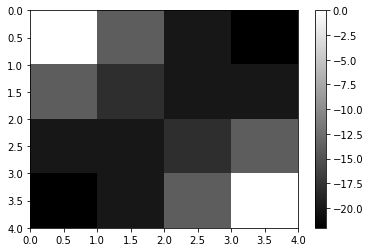

In [10]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [11]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [12]:
def policy_improvement(env, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    R, next_state = build_matrix()    
    
    while True:
        
        V = policy_eval(policy, env, discount_factor)
        
        policy_stable = True
        for idx in range(env.nS):
            old_action = np.argmax(policy[idx])         
            
            q_val = R[idx] + discount_factor * V[list(next_state[idx])]          
            
            new_action = np.argmax(q_val)
            policy[idx, :] = 0
            policy[idx, new_action] = 1
            
            if not(old_action == new_action):
                policy_stable = False
                
        if policy_stable:
            break            
    
    return policy, V

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



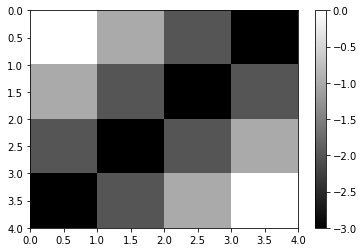

In [13]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [14]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [15]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    R, next_state = build_matrix()    
    # Implement!
    # YOUR CODE HERE
    while True:
        delta = 0
        
        for idx in range(env.nS):
            v = V[idx]
            V[idx] = np.amax(R[idx] + discount_factor * V[list(next_state[idx])])
            delta = max(delta, np.absolute(V[idx] - v))
            
        if delta < theta:
            # determine policy
            for idx in range(env.nS):
                q_val = R[idx] + discount_factor * V[list(next_state[idx])]
                action = np.argmax(q_val)
                policy[idx, action] = 1
                
            break
    
    return policy, V

In [16]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

YOUR ANSWER HERE

When the state values reach convergence, both approaches get same state value and same policy. We can see value iteration tolerate some error, truncate the policy evaluation process at some point and perform the policy improvement step over the approximate value function. However, policy interation has to wait to perform the policy improvement after convergence to the value function of the current policy, which is least efficent comparing to value iteration. 

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

YOUR ANSWER HERE

DP needs to know the distribution of next events, which is not easy to acquire in blackjack. In contrast, for Monte Carlo, we only need to sample mutiple epsiodes to compute the value finction. DP can be applied to situation with known transition probability. Monte Carlo can be applied when we are able to sample state-action trajectory.

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [17]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [18]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [19]:
# We can also look at the documentation/implementation of a method
?env.step

In [20]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [21]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    # YOUR CODE HERE
    current_sum, dealer_showing_card, usable_ace  = observation
        
    return 0 if current_sum >= 20 else 1


In [22]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(14, 7, False)
((16, 7, False), 0, False, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [23]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    # YOUR CODE HERE
    for idx_episode in tqdm(range(num_episodes)):
        
        # generate an episode according to policy
        # states and rewards in an episode
        state_list = []
        reward_list = []
        s = env.reset()
        
        while True:
            a = policy(s)
            obs, r, episode_done, _ = env.step(a)
            
            state_list += [s]
            reward_list += [r]  
            
            if episode_done:
                break 
                
            s = obs
                
        G = 0
        reward_list.reverse()
        for t, state in enumerate(reversed(state_list)):
            G = ( discount_factor * G ) + reward_list[t]
            first_index = state_list.index(state)
            
            if first_index == len(state_list) - 1- t:
                returns_sum[state] += G
                returns_count[state] += 1.0
            
                V[state] = returns_sum[state] / returns_count[state]
    
    return V

In [24]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
print(V)

100%|██████████| 1000/1000 [00:00<00:00, 15710.24it/s]

defaultdict(<class 'float'>, {(13, 4, False): -0.7777777777777778, (16, 7, False): -0.6923076923076923, (20, 10, False): 0.5352112676056338, (18, 10, False): -0.8611111111111112, (14, 10, False): -0.6285714285714286, (19, 6, False): -0.8235294117647058, (18, 5, False): -0.5294117647058824, (18, 5, True): -1.0, (13, 5, True): -1.0, (21, 10, False): 0.8260869565217391, (16, 10, False): -0.6304347826086957, (20, 4, False): 0.7333333333333333, (17, 10, False): -0.6578947368421053, (18, 10, True): -0.6, (21, 5, False): 0.8235294117647058, (14, 5, False): -0.4, (19, 5, False): -0.7272727272727273, (13, 5, False): -0.6923076923076923, (16, 3, False): -0.7, (15, 10, False): -0.8076923076923077, (19, 8, False): -0.5294117647058824, (20, 9, False): 0.6923076923076923, (21, 7, True): 1.0, (19, 3, False): -0.6, (13, 10, False): -0.5, (20, 10, True): 0.4, (13, 10, True): 1.0, (12, 5, False): -0.3333333333333333, (16, 5, False): -0.8, (19, 9, False): -0.8461538461538461, (18, 9, False): -0.5, (12, 1

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [25]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|██████████| 500000/500000 [00:34<00:00, 14663.73it/s]

CPU times: user 34.7 s, sys: 48.1 ms, total: 34.7 s
Wall time: 34.8 s


In [26]:
def draw_figure(ax, V, usable_ace):
    X = np.arange(1, 11, 1)
    Y = np.arange(12, 22, 1)

    X, Y = np.meshgrid(X, Y)
    Z = np.zeros((10, 10))

    for x in range(10):
        for y in range(10):
            obs = (Y[x,y], X[x,y], usable_ace)
            Z[x,y] = V[obs]
            
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    return surf
    

Approximate state-value functions for the blackjack policy

usable ace


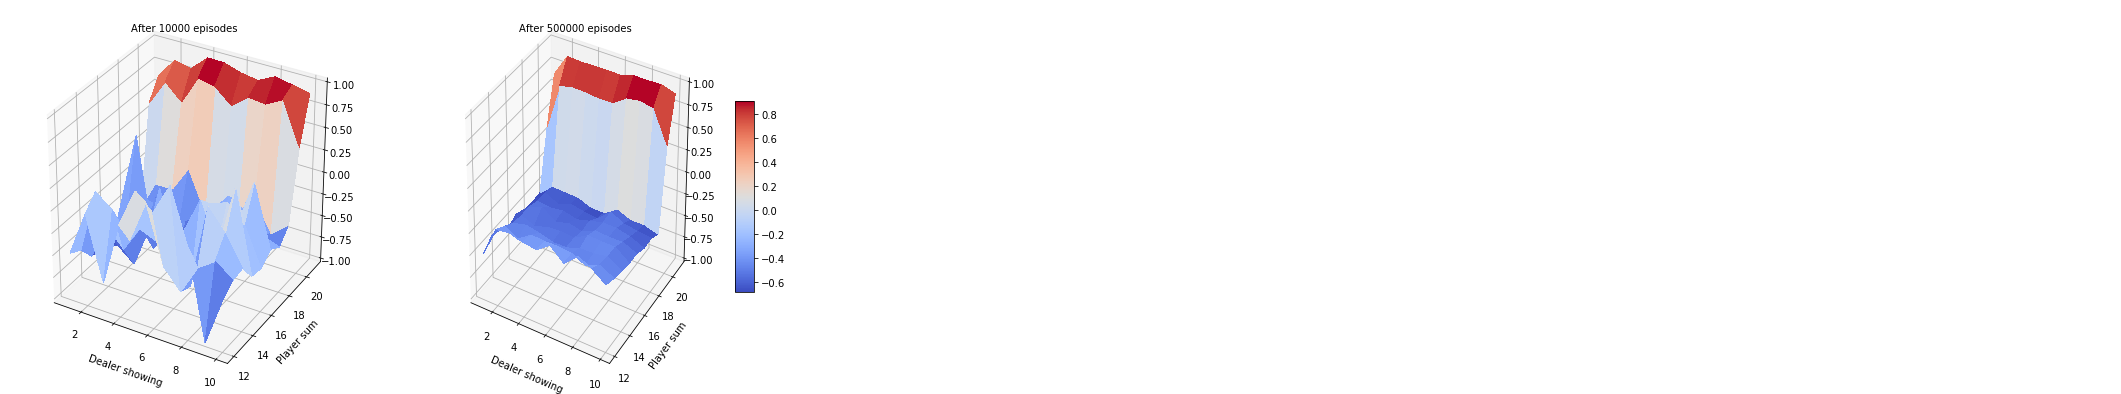

no usable ace


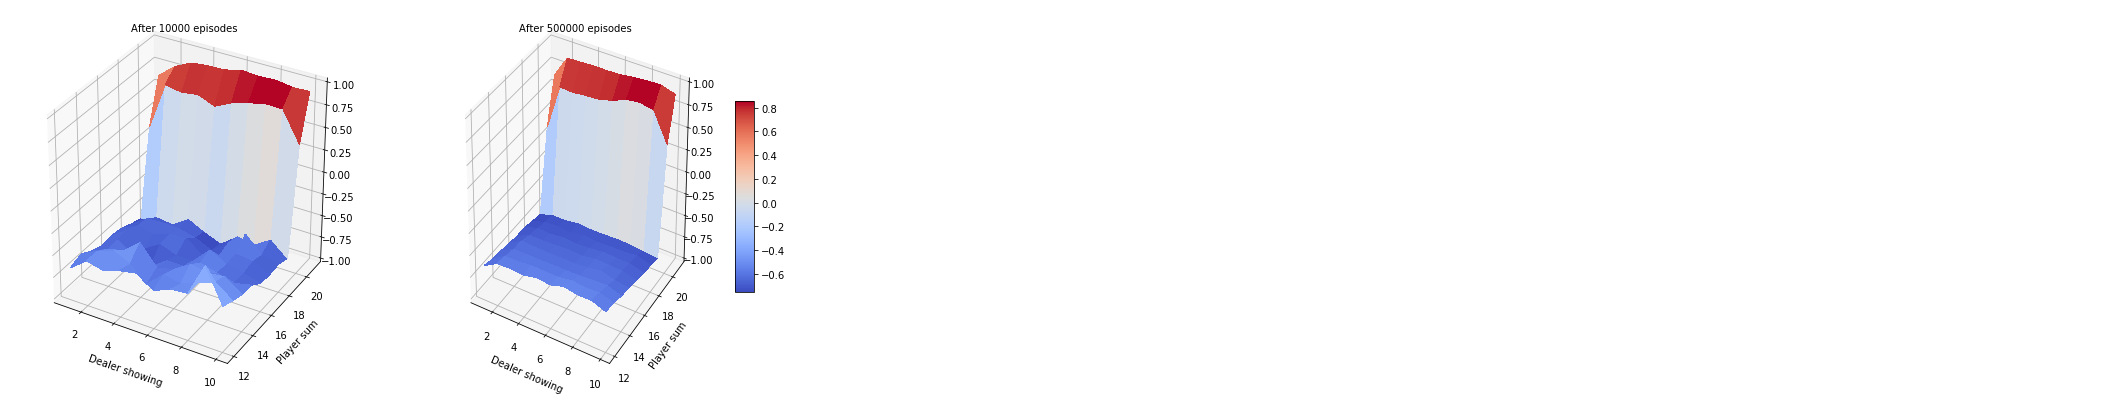

In [27]:
print('Approximate state-value functions for the blackjack policy\n')


fig2 = plt.figure(figsize=(14, 7))
print('usable ace')
ax = fig2.add_subplot(1, 2, 1, projection='3d')
surf = draw_figure(ax, V_10k, True)
ax.set_zlim(-1.0, 1.0)
ax.set_title('After 10000 episodes', fontsize = 10)

ax = fig2.add_subplot(1, 2, 2, projection='3d')
draw_figure(ax, V_500k, True)
ax.set_zlim(-1.0, 1.0)
ax.set_title('After 500000 episodes', fontsize = 10)
fig2.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

fig = plt.figure(figsize=(14, 7))
print('no usable ace')
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf= draw_figure(ax, V_10k, False)
ax.set_zlim(-1.0, 1.0)
ax.set_title('After 10000 episodes', fontsize = 10)

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = draw_figure(ax, V_500k, False)
ax.set_zlim(-1.0, 1.0)
ax.set_title('After 500000 episodes', fontsize = 10)

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy.

In [28]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # YOUR CODE HERE  
        a_max = np.random.choice(np.flatnonzero(Q[observation] == Q[observation].max()))        
        policy_prob = np.ones(nA) * epsilon / nA
        policy_prob[a_max] = 1 - epsilon + epsilon / nA
        return policy_prob
                
    return policy_fn

In [29]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # YOUR CODE HERE    
    count_episode = 0
    for count_episode in tqdm(range(num_episodes)):        
        
        s = env.reset()
        
        terminate = False
        #s_list = []
        #a_list = []
        s_a_list = []
        r_list = []
        while not terminate:
            a_probs = policy(s)
            a = np.random.choice(env.nA, 1, p = a_probs)[0]
            #print(a)
            
            result = env.step(a)     
            
            r = result[1]
            terminate = result[2]            
            #s_list += [s]
            #a_list += [a]
            s_a_list += [(s,a)]
            r_list += [r]
            
            s = result[0]
        
        G = 0.0
                
        for t in range(len(s_a_list) - 1, -1, -1):               
            G = discount_factor * G + r_list[t] # idx r is also from 0 to T-1
            s = s_a_list[t][0]
            a = s_a_list[t][1]
            s_a_pair = False
            
            if t > 0:
                for idx in range(t):
                    if s_a_list[idx] == s_a_list[t]:
                        s_a_pair = True
                        break
                
            if not (s_a_pair) or t == 0:
                returns_sum[s][a] += G
                returns_count[s][a] += 1
                Q[s][a] = returns_sum[s][a] / returns_count[s][a]
    
    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

100%|██████████| 10000/10000 [00:01<00:00, 5503.81it/s]


In [30]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [01:33<00:00, 5352.23it/s]

CPU times: user 1min 33s, sys: 104 ms, total: 1min 33s
Wall time: 1min 33s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

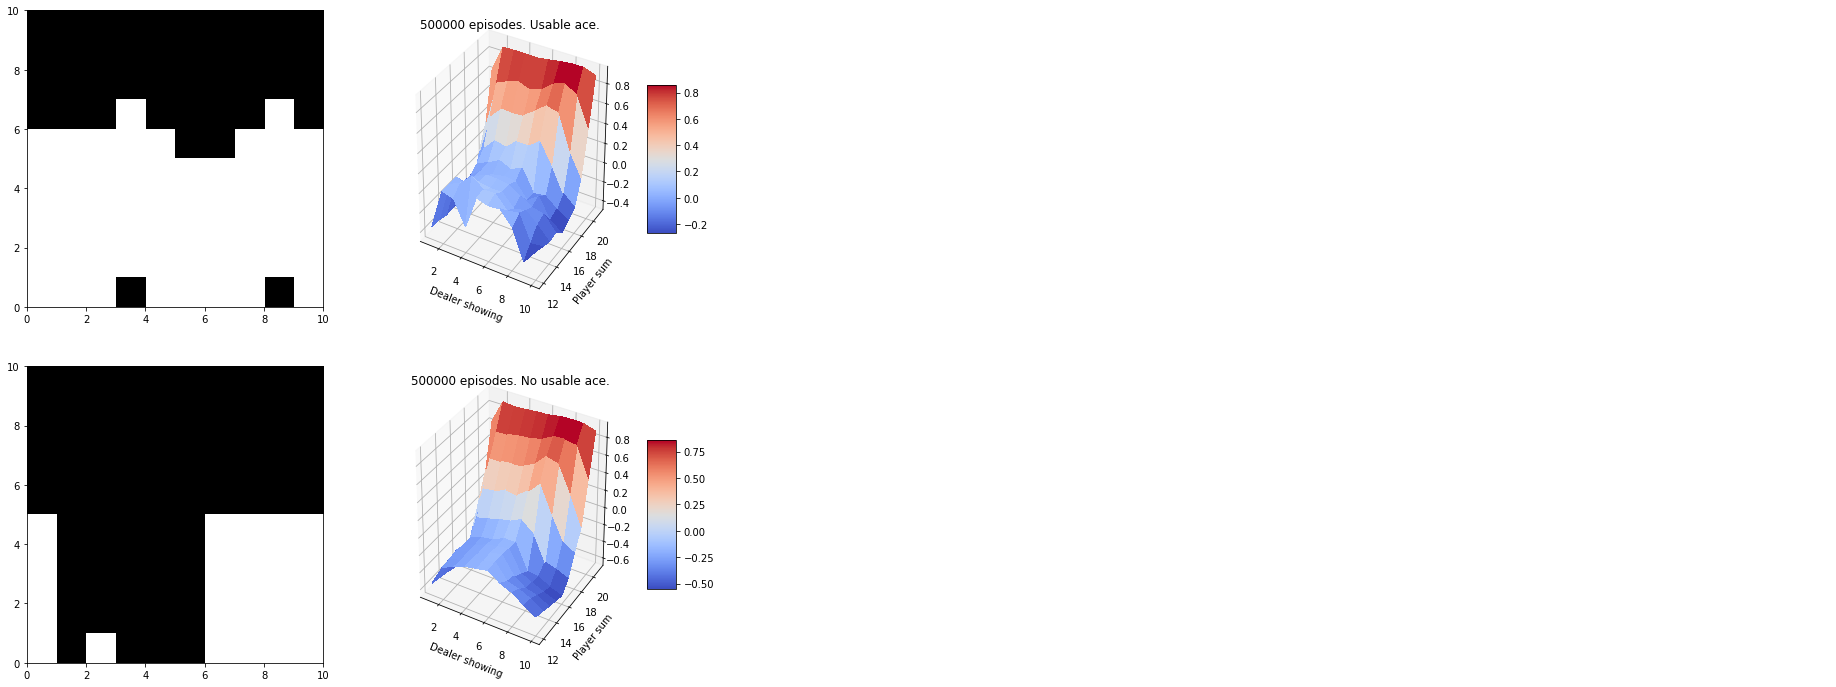

In [31]:
# YOUR CODE HERE
V_opt = defaultdict(float)
for key, value in Q.items():
    V_opt[key] = np.max(value)
    
x = range(1, 10 + 1)
y = range(12, 21 + 1)

z_a = np.zeros((10, 10))
z_noa = np.zeros((10, 10))

img_a = np.zeros((10, 10))
img_noa = np.zeros((10, 10))


for key, value in V_opt.items():
    if key[2] == True:        
        img_a[-(key[0]-12) + 9, key[1]-1] = np.argmax(policy(key)) * 1.0
        z_a[key[0]-12, key[1]-1] = value          
    else:
        img_noa[-(key[0]-12) + 9, key[1]-1] = np.argmax(policy(key)) * 1.0
        z_noa[key[0]-12, key[1]-1] = value

        
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(2, 2, 2, projection='3d')
surf = ax.plot_surface(x, y, z_a, cmap=cm.coolwarm, linewidth=1, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('500000 episodes. Usable ace.')
ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')

ax = fig.add_subplot(2, 2, 4, projection='3d')
surf = ax.plot_surface(x, y, z_noa, cmap=cm.coolwarm, linewidth=1, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('500000 episodes. No usable ace.')
ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')

ax = fig.add_subplot(2, 2, 1)
ax.imshow(img_a, cmap="gray", extent = [0,10,0,10])

ax = fig.add_subplot(2, 2, 3)
ax.imshow(img_noa, cmap="gray", extent = [0,10,0,10])

plt.show()

## 6. Temporal Difference (TD) learning (8 points)
Mention one advantage and one disadvantage of Monte Carlo methods. Mention an example where you would prefer to use TD learning.

YOUR ANSWER HERE

Monte Carlo methods can learn directly from raw experience without a model of the environment. However, this methods can't update estimates until finishing whole episode, which could take a lot of time. 

When an agent learns to play a video game, we can use TD learning so that we can learn immediately without waiting the end of the game.

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. In other words: implement SARSA. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [32]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

100%|██████████| 1000/1000 [00:02<00:00, 403.87it/s]


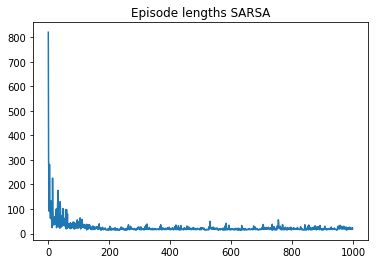

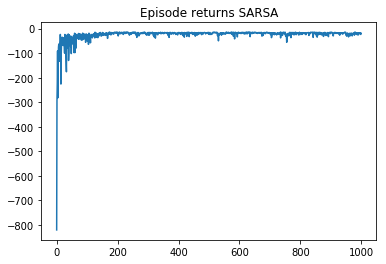

In [33]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        terminate = False        
        a_prob = policy(s)        
        a = np.random.choice(env.nA, 1, p = a_prob)[0]
        while not terminate:
            i += 1
            result = env.step(a)            
            r = result[1]
            R = discount_factor * R + r
            terminate = result[2]
            s_n = result[0]
            a_n_prob = policy(s_n)            
            a_n = np.random.choice(env.nA, 1, p = a_n_prob)[0]
           
            Q[s][a] = Q[s][a] + alpha * (r + discount_factor * Q[s_n][a_n] - Q[s][a])            
            s = s_n
            a = a_n                                        
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_sarsa)
plt.title('Episode lengths SARSA')
plt.show()
plt.plot(episode_returns_sarsa)
plt.title('Episode returns SARSA')
plt.show()

Since we might not be interested in falling off the cliff all the time, we can find another person to do this 'exploration' for us (in the name of science). Still, we would like to learn ourselfs from this persons policy, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

100%|██████████| 1000/1000 [00:01<00:00, 946.15it/s]


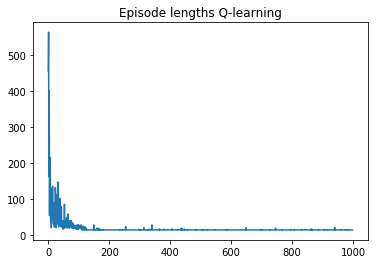

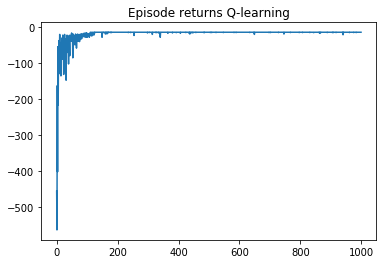

In [34]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        terminate = False        
        a_prob = policy(s)        
        a = np.random.choice(env.nA, 1, p = a_prob)[0]
        while not terminate:
            i += 1
            result = env.step(a)            
            r = result[1]
            R = discount_factor * R + r
            terminate = result[2]
            s_n = result[0]
            a_n_prob = policy(s_n)            
            a_n = np.argmax(a_n_prob)
           
            Q[s][a] = Q[s][a] + alpha * (r + discount_factor * Q[s_n][a_n] - Q[s][a])            
            s = s_n
            a = a_n     
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

Now compare the episode returns while learning for Q-learning and Sarsa (maybe run some more iterations?), by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, you may want to zoom in on the y-axis and smooth the returns (e.g. plotting the $n$ episode average instead). Which algorithm achieves higher return during learning? How does this compare to Example 6.6 from the book? Try to explain your observations.

In [35]:
AVERAGE_COUNT = 50
episode_lengths_sarsa_list = []
episode_returns_sarsa_list = []

episode_lengths_q_learning_list = []
episode_returns_q_learning_list = []

for idx in range(AVERAGE_COUNT):
    Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 500)
    Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) =q_learning(env, 500)
    
    episode_lengths_sarsa_list += [episode_lengths_sarsa]
    episode_returns_sarsa_list += [episode_returns_sarsa]
    
    episode_lengths_q_learning_list += [episode_lengths_q_learning]
    episode_returns_q_learning_list += [episode_returns_q_learning]

avg_episode_lengths_sarsa = np.mean(np.array(episode_lengths_sarsa_list), 0)
avg_episode_returns_sarsa = np.mean(np.array(episode_returns_sarsa_list), 0)


avg_episode_lengths_q_learning = np.mean(np.array(episode_lengths_q_learning_list), 0)
avg_episode_returns_q_learning = np.mean(np.array(episode_returns_q_learning_list), 0)

100%|██████████| 500/500 [00:00<00:00, 779.99it/s]


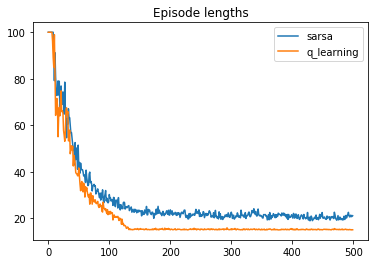

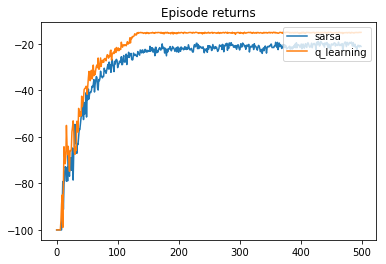

In [36]:
plt.plot(np.minimum(avg_episode_lengths_sarsa, 100))
plt.plot(np.minimum(avg_episode_lengths_q_learning, 100))
plt.legend(['sarsa', 'q_learning'], loc='upper right')
plt.title('Episode lengths')
plt.show()
plt.plot(np.maximum(avg_episode_returns_sarsa, -100))
plt.plot(np.maximum(avg_episode_returns_q_learning, -100))
plt.legend(['sarsa', 'q_learning'], loc='upper right')
plt.title('Episode returns')
plt.show()

YOUR ANSWER HERE

In this example, Q-learning method returns episods with less length comparing to sarsa, which is the same as Example 6.6. However, from the viewpoint of Q-learning's returning rewards comparing to Sarsa, Q-learning has difference performance in both examples. In this example, Q-learning is better than sarsa; in Example 6.6, it's the opposite result. The reason leading to this difference is the setting of the reward. 

In this example, all rewards is -1 on all transitions. Thus, finding the shortest path must lead to better returning reward. However, in the other example, in addtion to -1 of reward, there is also -100 of reward around "the Cliff". Finding the shortest path may results in sometimes falling off the cliff, leading worse returning reward comparing to sarsa, which chooses longer but safer path.

After we have learned the policy, we do not care about exploration any more and we may switch to a deterministic (greedy) policy instead. If we evaluate this for both Sarsa and Q-learning (actually, for Q-learning the learned policy is already deterministic), which policy would you expect to perform better? Why?

Q-learning should be better, because it reachs higher episode return. In the experiment below, it shows that Q-learning only needs 15 steps to reach the goal, but SARSA needs 17 steps.

Please run the experiments to test your hypothesis (print or plot your results). How many runs do you need to evaluate the policy? Note: without learning, the order of the episodes is not relevant so a normal `plt.plot` may not be the most appropriate choice.

In [43]:
Q_q_learning, (_, c) = q_learning(env, 1000)
Q_sarsa, (_, c1) = sarsa(env, 1000)

100%|██████████| 1000/1000 [00:02<00:00, 371.54it/s]


In [44]:
# we set epsilon as 0
policy = make_epsilon_greedy_policy(Q_sarsa, 0, env.action_space.n)

state_list = []
s = env.reset()
R = 0
terminal = False;
while not(terminal):
    action_prob = policy(s)        
    a = np.argmax(action_prob)
    s_1, r, episode_done, _ = env.step(a)
    env.render()
    state_list += [s]
    s = s_1       
    R = (R* 1) + r
    terminal = episode_done

print("SARSA Number of steps:", len(state_list), state_list)

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o

In [45]:
policy = make_epsilon_greedy_policy(Q_q_learning, 0, env.action_space.n)

state_list = []
s = env.reset()
R = 0
terminal = False;
while not(terminal):
    action_prob = policy(s)
    a = np.argmax(action_prob)
    s_1, r, episode_done, _ = env.step(a)
    env.render()
    state_list += [s]
    s = s_1       
    R = (R* 1) + r
    terminal = episode_done

print("Q-learning Number of steps:", len(state_list), state_list)

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o